In [16]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import requests
from PIL import Image
from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)
from utils.keypoints import get_gaussian_scoremap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
url = "http://images.cocodataset.org/val2017/000000000139.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('/Users/johncao/Documents/Programming/Stanford/CS224G/finetune/utils/test_imgs/blazer_illustration_front.png')

# ------------------------------------------------------------------------
# Stage 1. Detect humans on the image
# ------------------------------------------------------------------------

# You can choose detector by your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes = result["boxes"][result["labels"] == 0]
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple")
print(sum(p.numel() for p in model.parameters()))

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes], threshold=0.3)
image_pose_result = pose_results[0]  # results for first image

fig = plt.figure()
plt.imshow(image)
for i, person_pose in enumerate(image_pose_result):
    print(f"Person #{i}")
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        keypoint_name = model.config.id2label[label.item()]
        x, y = keypoint
        print(f" - {keypoint_name}: x={x.item():.2f}, y={y.item():.2f}, score={score.item():.2f}")
        plt.scatter(x,y)
plt.show()



85912337


ValueError: not enough values to unpack (expected 2, got 1)

In [7]:
print(inputs['pixel_values'].shape)
im = inputs['pixel_values'].permute(0,2,3,1)
plt.imshow(im[0])

plt.show()

torch.Size([0])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].


(256, 192, 3)
VitPoseSimpleDecoder(
  (activation): ReLU()
  (upsampling): Upsample(scale_factor=4.0, mode='bilinear')
  (conv): Conv2d(768, 17, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


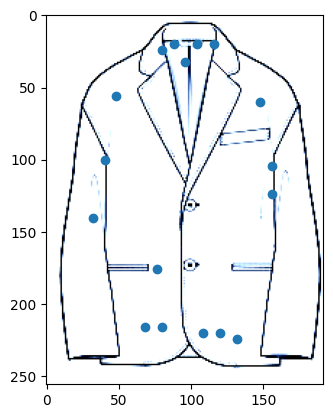

In [14]:
def normalize_image(image: Image.Image):
    """
    Normalizes a PIL image using the given mean and standard deviation.
    
    Args:
        image (PIL.Image.Image): The input image.
    
    Returns:
        np.ndarray: The normalized image as a NumPy array.
    """
    # Convert image to NumPy array (scale to [0,1])
    image_array = np.array(image).astype(np.float32) / 255.0

    # Define mean and standard deviation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Normalize (broadcasting across channels)
    normalized_image = (image_array - mean) / std

    return normalized_image

def extract_keypoints_from_heatmap(heatmap):
    """
    Extracts keypoint coordinates from predicted heatmaps.

    Args:
        heatmap: Tensor of shape (N_k, H, W)

    Returns:
        keypoints: List of (x, y) keypoints
    """
    N_k, H, W = heatmap.shape
    keypoints = []
    for i in range(N_k):
        # Get index of max value in heatmap
        idx = torch.argmax(heatmap[i])
        y, x = divmod(idx.item(), W)  # Convert to (y, x) coordinates
        keypoints.append((x, y))

    return keypoints

normalized_image = normalize_image(image.resize([192,256]))
x = torch.tensor(normalized_image).permute(2,0,1).unsqueeze(0).float()
print(normalized_image.shape)
out = model(x)
kpts = extract_keypoints_from_heatmap(out['heatmaps'][0])
print(model.head)
kpts_list = []
for kp in kpts:
    kpts_list.append([kp[0], kp[1]])

kpts = np.array(kpts_list)*4

fig = plt.figure()
plt.imshow(normalized_image)
plt.scatter(x=kpts[:,0], y=kpts[:,1])
plt.show()

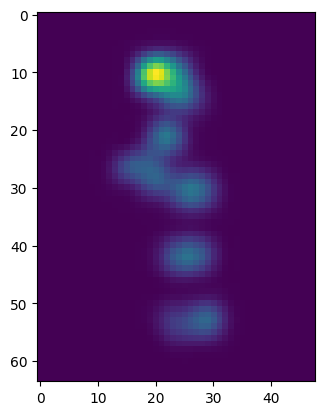

In [57]:
heatmap = torch.sum(map, dim=0)
fig = plt.figure()
plt.imshow(heatmap)
plt.show()

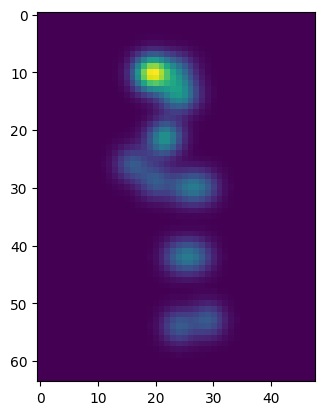

In [64]:
points = kpts/4
fig = plt.figure()
score_map_all = 0
for i in range(17):
    score_map = get_gaussian_scoremap((64,48), points[i], sigma=2)
    score_map_all += score_map
plt.imshow(score_map_all)
plt.show()

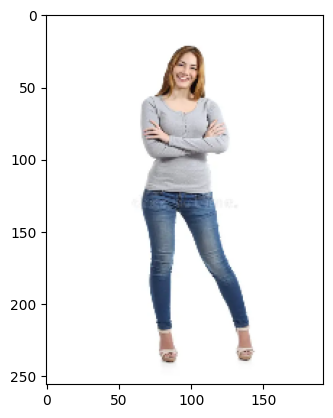

In [84]:
image = cv2.imread('person.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_orig = cv2.resize(image,[192,256])
fig = plt.figure()
plt.imshow(image_orig)
plt.show()
image = torch.from_numpy(np.array(image_orig)).permute(2,0,1).unsqueeze(0).float()

In [3]:
get_gaussian_scoremap([50,50],np.array([]))

ValueError: operands could not be broadcast together with shapes (50,50,2) (0,) 

array([], dtype=float64)